In [1]:
!pip install emoji

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

import re
import regex
import emoji
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [3]:
#Si se usa colab, ejecutar esta celda
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definir funciones necesarias 

In [4]:
# Patron regex para identificar el comienzo de cada línea del txt con la fecha y la hora
def IniciaConFechaYHora(s):
    # Ejemplo: '21/2/2021 11:27 a. m. - ... '
    patron = '^([1-9]|1[0-9]|2[0-9]|3[0-1])(\/)([1-9]|1[0-2])(\/)(2[0-9][0-9][0-9]) ([0-9]+):([0-9][0-9]) (a.\xa0m.|p.\xa0m.) -'
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    if resultado:
        return True
    return False
  
# Patron para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = [
        '([\w]+):',                                    # Nombre
        '([\w]+[\s]+[\(]+[\w]+[\)]+):',      # Nombre (Apodo)
        '([\w]+[\s]+[\w]+):',                    # Nombre + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # Nombre 1 + Nombre 2 + Apellido
        '([+]\d{2} \d{3} \d{3} \d{3}):',     # Número de teléfono (Peru)
        '([\w]+)[\u263a-\U0001f999]+:', # Nombre + Emoji            
    ]
    patron = '^' + '|'.join(patrones)     
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    if resultado:
        return True
    return False
  
# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):   
    # Ejemplo: '21/2/2021 11:27 a. m. - Sandro: Todos debemos aprender a analizar datos'
    splitLinea = linea.split(' - ') 
    FechaHora = splitLinea[0]                     # '21/2/2021 11:27 a. m.'
    splitFechaHora = FechaHora.split(' ')   
    Fecha = splitFechaHora[0]                    # '21/2/2021'
    Hora = ' '.join(splitFechaHora[1:])          # '11:27 a. m.'
    Mensaje = ' '.join(splitLinea[1:])             # 'Sandro: Todos debemos aprender a analizar datos'
    if EncontrarMiembro(Mensaje): 
        splitMensaje = Mensaje.split(': ')      
        Miembro = splitMensaje[0]               # 'Sandro' 
        Mensaje = ' '.join(splitMensaje[1:])    # 'Todos debemos aprender a analizar datos'
    else:
        Miembro = None
    return Fecha, Hora, Miembro, Mensaje

# Obtener el dataframe usando el archivo txt y las funciones definidas

In [5]:
# Leer el archivo txt descargado del chat de WhatsApp
RutaChat = 'Chat de WhatsApp con Data Analytics IISE 2021.txt'

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt 
DatosLista = [] 
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    VerificarMensaje = [] # Lista para verificar que no existan mensajes vacíos 
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline() 
        if not linea: 
            break
        linea = linea.strip() 
        if IniciaConFechaYHora(linea): # Si cada línea del txt coincide con el patrón fecha y hora
            if len(VerificarMensaje) > 0: 
                # Añadir un elemento lista que contendrá los datos a la lista 'DatosLista' 
                DatosLista.append([Fecha, Hora, Miembro, ' '.join(VerificarMensaje)]) 
            VerificarMensaje.clear() 
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            VerificarMensaje.append(Mensaje) 
        else:
            VerificarMensaje.append(linea)

# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje']) 

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%Y")

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Rester el índice
df.reset_index(drop=True, inplace=True)
df

,Fecha,Hora,Miembro,Mensaje
0,2021-01-28,11:26 p. m.,Sandro,Llegas a ese nombre de grupo?
1,2021-01-28,11:28 p. m.,Roxana Analytics,Mmm puedes ser xd
2,2021-01-28,11:28 p. m.,Sandro,cámbiale
3,2021-01-28,11:28 p. m.,Sandro,para ver cuál queda mejor
4,2021-01-28,11:28 p. m.,Sandro,o cuáles
...,...,...,...,...
1334,2021-02-28,3:24 p. m.,Daniel Godoy,<Multimedia omitido>
1335,2021-02-28,3:31 p. m.,Manuel Alcántara,<Multimedia omitido>
1336,2021-02-28,6:46 p. m.,Astrid Analytics,Listo! 👌
1337,2021-02-28,8:58 p. m.,Carlos Loayza,<Multimedia omitido>


# Estadísticas de mensajes, multimedia, emojis y links

### Total de mensajes, multimedia, emojis y links enviados

In [6]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje) # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if any(c in emoji.UNICODE_EMOJI['es'] for c in caracter): # Obtener emojis en idioma español: 'es'
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0] 

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0] 

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: re.findall(url_patron, x)).str.len() # Se agrega columna 'URLs'
links = np.sum(df.URLs)

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,1339
Multimedia,394
Emojis,654
Links,73


In [7]:
# Dataframe principal con las columnas 'Emojis' y 'URLs' agregadas 
df.tail(10)

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs
1329,2021-02-28,1:13 p. m.,Jesús Cucho,Todo feedback es totalmente recibido,[],0
1330,2021-02-28,1:20 p. m.,Sergio Valera,Listo,[],0
1331,2021-02-28,1:37 p. m.,Alessandro Huamán,Xd,[],0
1332,2021-02-28,2:02 p. m.,Mateo Analytics,<Multimedia omitido>,[],0
1333,2021-02-28,2:05 p. m.,Leonardo Maraví,Ya esta XD,[],0
1334,2021-02-28,3:24 p. m.,Daniel Godoy,<Multimedia omitido>,[],0
1335,2021-02-28,3:31 p. m.,Manuel Alcántara,<Multimedia omitido>,[],0
1336,2021-02-28,6:46 p. m.,Astrid Analytics,Listo! 👌,[👌],0
1337,2021-02-28,8:58 p. m.,Carlos Loayza,<Multimedia omitido>,[],0
1338,2021-02-28,10:02 p. m.,Jorge Huamán,<Multimedia omitido>,[],0


### Emojis más usados

In [8]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df.head(10)

Número emojis únicos usados:  86 



,Cantidad
Emoji,
🥳,98
😁,66
🤩,60
🙌,51
🎉,39
🙌🏻,34
💪,26
😅,22
💙,16


In [9]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Pie de emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Cuando agregamos archivos Jupyter Notebook o IPython Notebook con una extensión .ipynb en GitHub
# se mostrarán como archivos HTML estáticos en su repositorio, pero los gráficos de trazado son interactivos

# Estadísticas de los miembros del grupo

### Miembros más activos

In [10]:
# Identificar a todos los miembros del grupo
df.Miembro.unique()

array(['Sandro', 'Roxana Analytics', 'Johann Jojos', 'Marco Aragón',
       'Alessandro Huamán', 'Ivonne Chan', 'Joselin Diestra',
       'Frank Sánchez', 'Roberto Berrocal', 'Sergio Valera',
       'Jorge Palomino', 'Carlos Loayza', 'Leonardo Maraví',
       'Daniel Godoy', 'Jesús Cucho', 'Claudia Analytics',
       'Jessica Significación', 'José Tupayachi', 'Astrid Analytics',
       'Mateo Analytics', 'Erik Romero GTH', 'Paola GTH',
       'Fernando Briones', 'Jorge Huamán', 'Nikol Cotrina',
       'Eduardo IISE', 'Marco Jorge', 'David Analytics',
       'Yusseli Analytics', 'Manuel Alcántara'], dtype=object)

In [11]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos.head(10)

,Miembro,Mensaje
1,Sandro,221
2,Roxana Analytics,141
3,Eduardo IISE,99
4,Alessandro Huamán,96
5,Jesús Cucho,84
6,José Tupayachi,75
7,Joselin Diestra,70
8,Mateo Analytics,58
9,Ivonne Chan,51
10,Johann Jojos,42


### Estadísticas por miembro

In [12]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,Letras,Palabras
1329,2021-02-28,1:13 p. m.,Jesús Cucho,Todo feedback es totalmente recibido,[],0,36,5
1330,2021-02-28,1:20 p. m.,Sergio Valera,Listo,[],0,5,1
1331,2021-02-28,1:37 p. m.,Alessandro Huamán,Xd,[],0,2,1
1333,2021-02-28,2:05 p. m.,Leonardo Maraví,Ya esta XD,[],0,10,3
1336,2021-02-28,6:46 p. m.,Astrid Analytics,Listo! 👌,[👌],0,8,2


In [13]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
  lista = []
  # Filtrar mensajes de un miembro en específico
  miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

  # Agregar a la lista el número total de mensajes enviados
  lista.append(miembro_df.shape[0])

  # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
  palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
  lista.append(palabras_por_msj )

  # Agregar a la lista el número de mensajes multimedia enviados
  multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
  lista.append(multimedia)

  # Agregar a la lista el número total de emojis enviados
  emojis = sum(miembro_df['Emojis'].str.len())
  lista.append(emojis)

  # Agregar a la lista el número total de links enviados
  links = sum(miembro_df['URLs'])   
  lista.append(links)

  # Asignar la lista como valor a la llave del diccionario
  dictionario[miembros[i]] = lista
print(dictionario)

{'Sandro': [141, 9.801418439716311, 80, 87, 14], 'Roxana Analytics': [90, 11.588888888888889, 51, 137, 17], 'Marco Aragón': [4, 3.75, 2, 5, 1], 'Alessandro Huamán': [76, 5.0, 20, 5, 1], 'Ivonne Chan': [34, 7.117647058823529, 17, 18, 0], 'Joselin Diestra': [67, 12.522388059701493, 3, 173, 2], 'Frank Sánchez': [13, 2.923076923076923, 5, 3, 0], 'Roberto Berrocal': [37, 5.081081081081081, 4, 6, 0], 'Sergio Valera': [30, 4.866666666666666, 9, 1, 2], 'Jorge Palomino': [3, 5.0, 0, 0, 0], 'Leonardo Maraví': [16, 5.0625, 12, 9, 0], 'Jesús Cucho': [52, 6.153846153846154, 32, 27, 2], 'Claudia Analytics': [3, 1.6666666666666667, 1, 0, 0], 'Jessica Significación': [6, 4.666666666666667, 2, 11, 0], 'Carlos Loayza': [11, 2.3636363636363638, 22, 1, 2], 'José Tupayachi': [45, 6.266666666666667, 30, 22, 5], 'Astrid Analytics': [34, 5.176470588235294, 0, 41, 4], 'Mateo Analytics': [31, 3.4838709677419355, 27, 22, 1], 'Erik Romero GTH': [20, 22.9, 8, 36, 8], 'Paola GTH': [11, 16.90909090909091, 10, 11, 2]

In [14]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df.head(10)

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Sandro,141,9.801418,80,87,14
Roxana Analytics,90,11.588889,51,137,17
Marco Aragón,4,3.750000,2,5,1
Alessandro Huamán,76,5.000000,20,5,1
Ivonne Chan,34,7.117647,17,18,0
Joselin Diestra,67,12.522388,3,173,2
Frank Sánchez,13,2.923077,5,3,0
Roberto Berrocal,37,5.081081,4,6,0
Sergio Valera,30,4.866667,9,1,2
Jorge Palomino,3,5.000000,0,0,0


# Estadísticas del comportamiento del grupo

### Días y horas en las que el grupo estuvo más activo

Text(0, 0.5, 'Fecha')

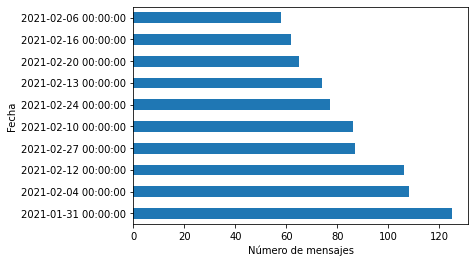

In [15]:
# Determinar los días más activos del grupo
df['Fecha'].value_counts().head(10).plot.barh() # Plotear 10 días
plt.xlabel('Número de mensajes')
plt.ylabel('Fecha')

Text(0, 0.5, 'Fecha')

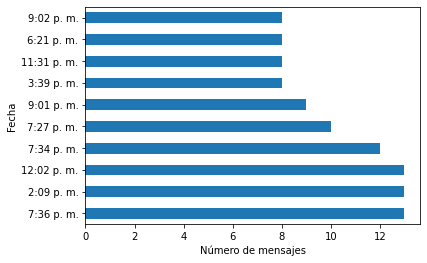

In [16]:
# Determinar las horas en las que el grupo está más activo
df['Hora'].value_counts().head(10).plot.barh() 
plt.xlabel('Número de mensajes')
plt.ylabel('Fecha')

### Word Cloud de palabras más usadas por el grupo

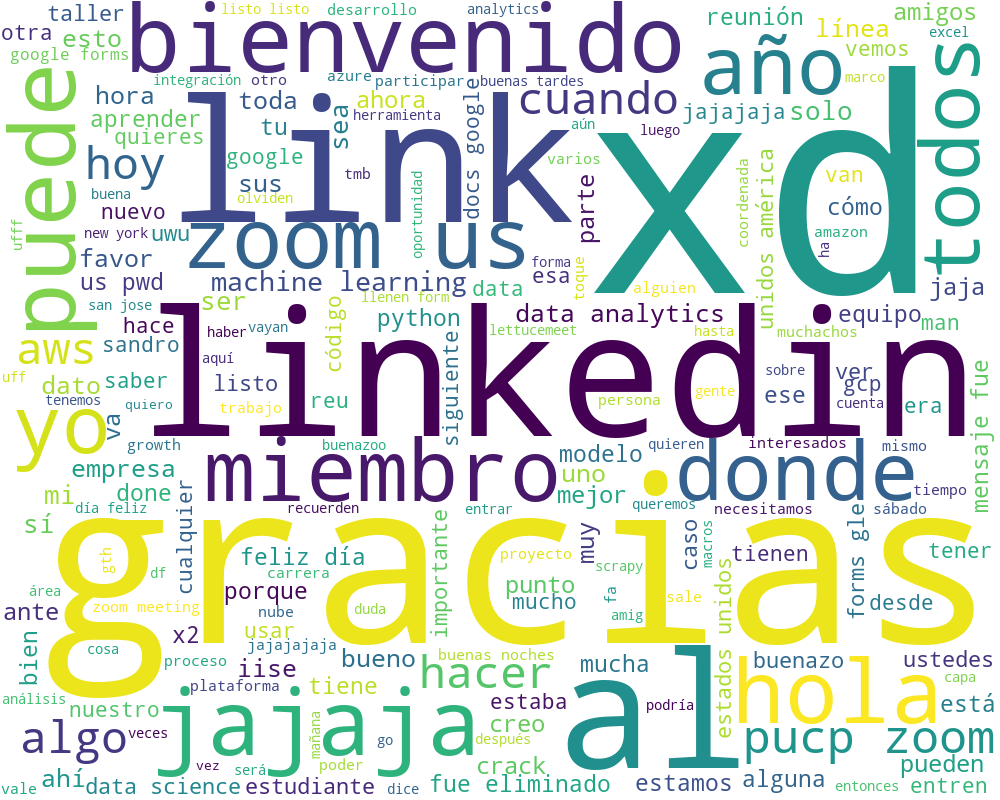

In [17]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es', 
                                                         'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta', 
                                                         'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
                                                         'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
                                                         'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han'])

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
  palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
  for palabra in palabras:
    total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(total_palabras) 

# Plotear la nube de palabras más usadas
wordcloud.to_image()

### Número de mensajes a través del tiempo

In [18]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'}, 
    font=dict(
        size=17))
fig.update_xaxes(nticks=20)
fig.show()

# Cuando agregamos archivos Jupyter Notebook o IPython Notebook con una extensión .ipynb en GitHub
# se mostrarán como archivos HTML estáticos en su repositorio, pero los gráficos de trazado son interactivos